# Scarcity Model
This notebook runs the model and plots the output. For more detail about model components, see `model_elements.ipynb` or consult the `models.py` code. The results should not be considered definitive, but they are roughly based on the methods described in the Clingendael Institute reports (all errors are ours alone!):

- [Sudan: From hunger to death](https://www.clingendael.org/publication/sudan-hunger-death) 
2024-05-24, Dr. Timmo Gaasbeek. 

- [From Catastrophe to Famine: Immediate action needed in Sudan to contain mass starvation](https://www.clingendael.org/publication/catastrophe-famine-immediate-action-needed-sudan-contain-mass-starvation) 2024-02-08. Anette Hoffmann. 

At some points we likely diverge from their approach, such as in the linear and piecewise linear approaches to initial BMI levels, and in the distribution of calories across the population.

In [1]:

import pandas as pd
import warnings

import os
import re
import json
import numpy as np

from pathlib import Path
import math
import warnings
import matplotlib.pyplot as plt


try: # identify if in colab to fix paths
    import google.colab
    IN_COLAB = True
    print("colab identified.")
except ImportError:
    IN_COLAB = False

In [2]:
# clone the repository to access the data

!git clone https://github.com/aristotle-tek/famine-prediction.git


In [ ]:
if IN_COLAB: # fix for paths in colab
    base_path = Path('/content/famine-prediction')
else:
    try:
        base_path = Path(__file__).resolve().parent.parent
    except NameError:
        base_path = Path.cwd().parent.parent
print("Base path: ", base_path)

In [3]:
os.chdir(base_path)
from src.models import ResourceScarcityModel


## Setup - initialization, assumptions

For now we will focus on modeling October 2023-September 2024. Our analysis will model each percentile of the population separately, for each month. We input some choices about how to model the distribution of calories across the population (details below), and an initial distribution of BMI across the percentiles.

1. We input data on population, percent calories from grain, the time period, and calories per metric ton. (See the [discussion here](https://theoryandaction.substack.com/p/transparent-famine-models-i-counting) for info on adding up sources of food and converting them to kcal, or the `est_kcal_walkthrough.ipynb` notebook).

2. Given the stock of calories for a year, some of which are added over the course of the year as grain is harvested, etc. there is still the question of how these calories are consumed over time, subject to the availability constraint. For now we use a pre-defined `monthly_total_demand` figures that are generally decreasing over the year. Later, we could consider optimal distributions, or other more realistic options, but for now we'll just assume the above consumption, which is roughly decreasing over time, until basically all stocks are consumed by the end of the lean season (September 2024).

3. For a step-by-step breakdown of the ResourceScarcityModel class, as well as more details about how calories are distributed over the population, and initial BMI stats, see the associated `model_elements.ipybn` notebook.

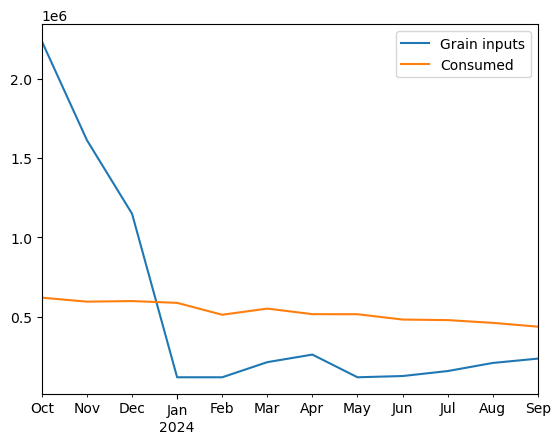

In [17]:

# Configuration parameters
config = {
    'total_pop': 48.6e6,
    'grain_percentage': 0.70,
    'grain_multiplier': 1.0,
    'grain_stock': [
        2235333.25,  # Opening stock
        1612401,     # input for Oct 2023 (not Sept)
        1149472.25,
        119215,
        119215,
        214471,
        262099,
        119215,
        127055,
        158415,
        209375,
        236815
    ],
    'start_year': 2023,
    'start_month': 10,
    'num_months': 12,
    'monthly_total_demand': [
        620553.9045, 595536.1334, 599163.7419, 587906.9105,
        513001.394, 551827.9642, 516732.8528, 516273.2652,
        482784.4238, 479255.9897, 461943.8986, 438037.1914
    ],
    'calories_per_metric_ton': 3_500_000,
    'bmi_init_method': 'linear',  # 'linear', logarithmic,  or 'reference'
    'distrib_min_kcal': 700,
    'top_bmi': 30,                   # for if 'linear' or logarithmic method is selected
    'distrib_method': 'piecewise_linear',  # 'linear' or 'piecewise_linear'
    'distrib_beta1': 3, # slope of the linear distribution or of the first segm of the linear piecewise
    'distrib_c': 80,
    'critical_bmi': 10.0
}

# Optional - small plot to show the grain inputs and consumption
pd.DataFrame({'Grain inputs': config['grain_stock'], 'Consumed': config['monthly_total_demand']}, index=pd.date_range(start=f"{config['start_year']}-{config['start_month']:02d}", periods=config['num_months'], freq='ME')).plot(); plt.show()



In [ ]:
# Run the model - note see the model class for more details on the model! (and below for some key points)
scarcityModel = ResourceScarcityModel(config)
scarcityModel.run_simulation()
results = scarcityModel.get_results()


print("Total deaths: ", str(int(results['total_deaths'].sum())))


In [21]:
# output percentile data
percentile_data = scarcityModel.get_percentile_data()
# look at one percentile: 
p25 = percentile_data[percentile_data['percentile'] == 25]
p25

,percentile,bmi,pop,alive,kcal_distrib,deficit,excess_mortality_rate,deaths_excess_mortality,month
24,25,20.634725,486959.850000,True,1371.416000,0.109470,0.000000,0.0,2023-10-01
124,25,20.352526,487296.595639,True,1356.616995,0.119080,0.000000,0.0,2023-11-01
224,25,20.010574,487009.001361,True,1318.069679,0.144111,0.000000,0.0,2023-12-01
324,25,19.643806,485972.056423,True,1292.832989,0.160498,0.000000,0.0,2024-01-01
424,25,19.113444,484933.539214,True,1203.961333,0.218207,0.000000,0.0,2024-02-01
524,25,18.655413,484518.226084,True,1214.820551,0.211155,0.000000,0.0,2024-03-01
624,25,18.149556,484836.085659,True,1174.435431,0.237380,0.000292,141.0,2024-04-01
724,25,17.716005,485189.549572,True,1132.367540,0.229682,0.000472,228.0,2024-05-01
824,25,17.225978,484944.495166,True,1091.052002,0.257788,0.000923,448.0,2024-06-01
924,25,16.676700,483442.221638,True,1046.328104,0.288212,0.002212,1072.0,2024-07-01


## Plots

In [ ]:

from src.plot_utils import plot_percentiles_heatmap, cmap_bmi, cmap_kcal, cmap_mortality


plots_folder = base_path / 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
print("Plots folder: ", plots_folder)

In [9]:

months_sorted = sorted(percentile_data['month'].unique())


# Create x_labels as formatted month strings
x_labels = [month.strftime('%m-%Y') if hasattr(month, 'strftime') else str(month) for month in months_sorted]
y_labels = np.arange(1, 101)

# Create pivot tables and plot heatmaps
variables_to_plot = {
    'bmi': {
        'cmap': cmap_bmi,
        'vmin': 15,
        'vmax': 22,
        'title': 'BMI over Time',
        'filename': 'bmi_heatmap.png'
    },
    'kcal_distrib': {
        'cmap': cmap_kcal,
        'vmin': 600,
        'vmax': 1540,
        'title': 'Average Kcal Grains per Day',
        'filename': 'kcal_heatmap.png'
    },
    'excess_mortality_rate': {
        'cmap': cmap_mortality,
        'vmin': 0,
        'vmax': 0.01,
        'title': 'Excess Mortality Rate',
        'filename': 'excess_mortality_heatmap.png'
    },
    'pop': {
        'cmap': 'viridis',
        'vmin': None,
        'vmax': None,
        'title': 'Population per Percentile over Time',
        'filename': 'population_heatmap.png'
    }
}


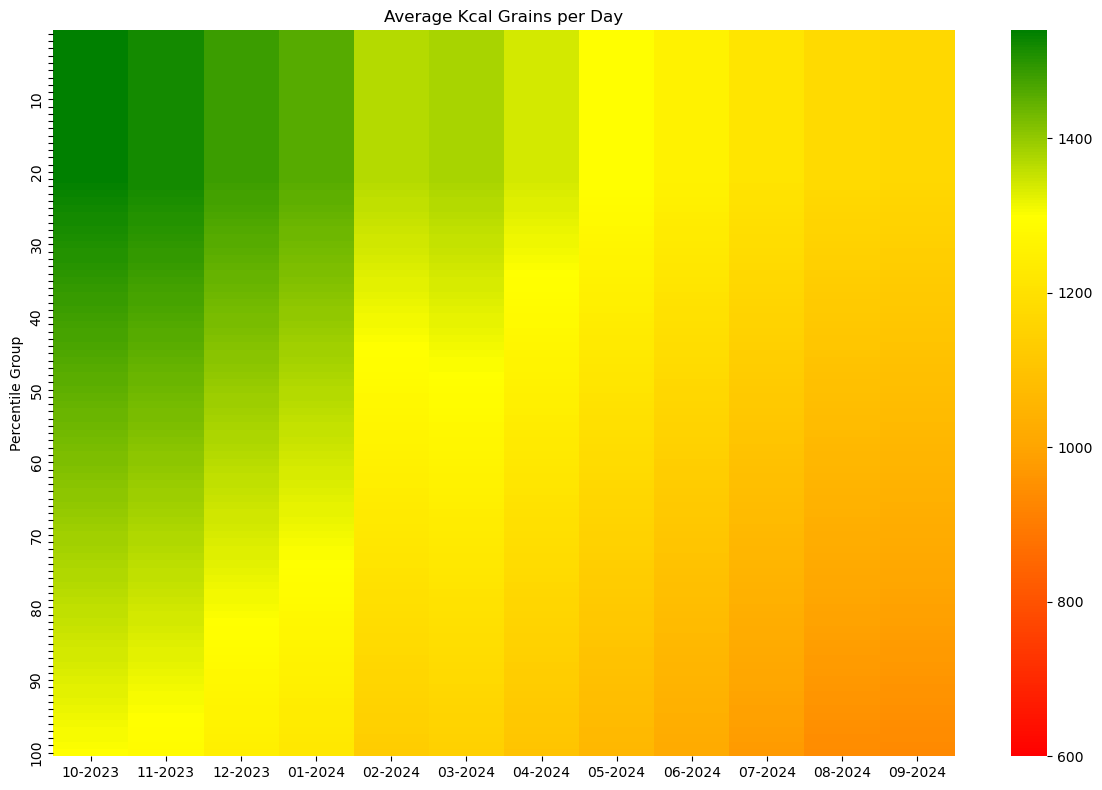

In [12]:
# Plot average kcal per day by percentile, month
var = 'kcal_distrib'
params = variables_to_plot[var]
data_pivot = percentile_data.pivot(index='percentile', columns='month', values=var)
data_pivot = data_pivot.reindex(index=y_labels, columns=months_sorted)
data_pivot_rev = data_pivot.iloc[::-1]

plot_percentiles_heatmap(
    data_pivot_rev,
    title=params['title'],
    cmap=params['cmap'],
    vmin=params['vmin'],
    vmax=params['vmax'],
    filename= str(plots_folder) + params['filename'],
    x_labels=x_labels,
    show=True,
)


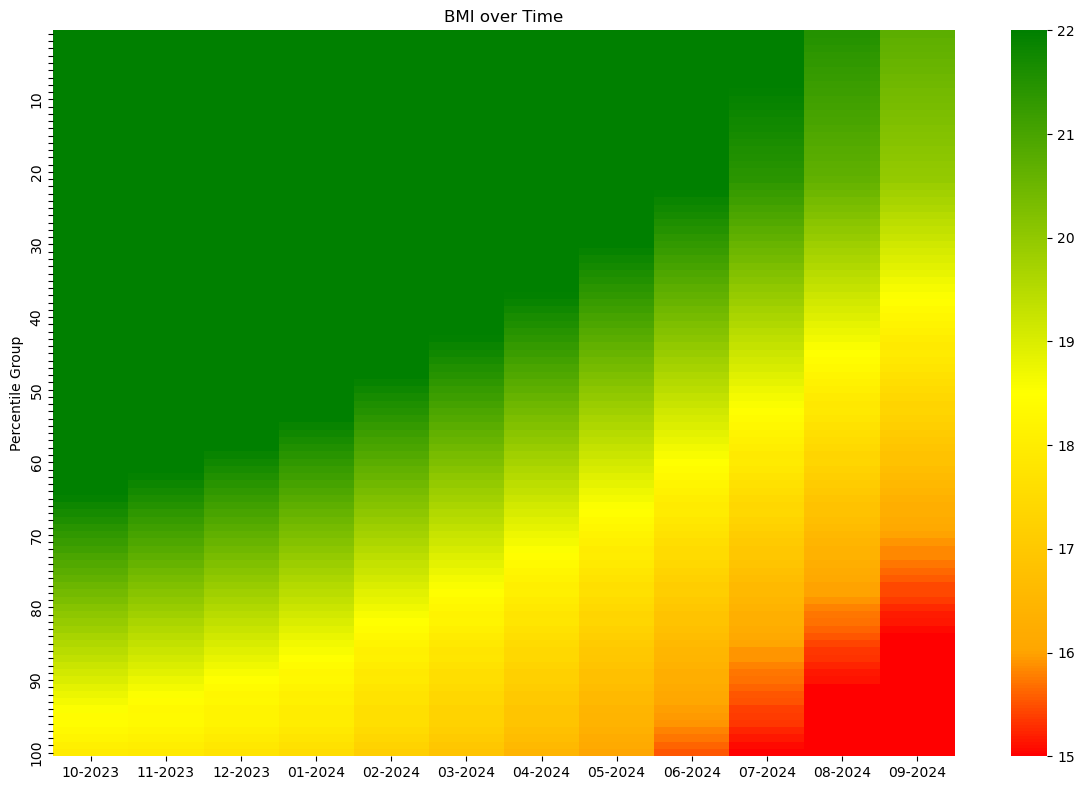

In [10]:
# Plot BMI by month
var = 'bmi'
params = variables_to_plot[var]
data_pivot = percentile_data.pivot(index='percentile', columns='month', values=var)
data_pivot = data_pivot.reindex(index=y_labels, columns=months_sorted)
data_pivot_rev = data_pivot.iloc[::-1]

plot_percentiles_heatmap(
    data_pivot_rev,
    title=params['title'],
    cmap=params['cmap'],
    vmin=params['vmin'],
    vmax=params['vmax'],
    filename= str(plots_folder) + params['filename'],
    x_labels=x_labels,
    show=True
)


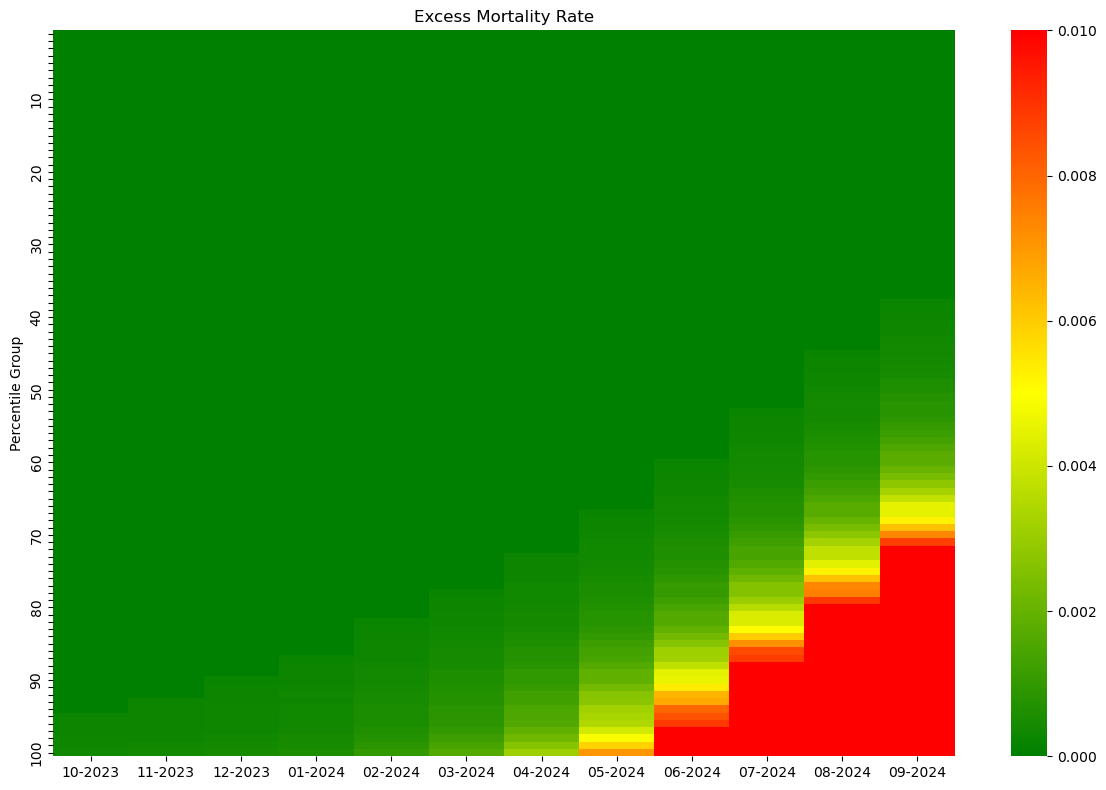

In [13]:
var = 'excess_mortality_rate'
params = variables_to_plot[var]
data_pivot = percentile_data.pivot(index='percentile', columns='month', values=var)
data_pivot = data_pivot.reindex(index=y_labels, columns=months_sorted)
data_pivot_rev = data_pivot.iloc[::-1]

plot_percentiles_heatmap(
    data_pivot_rev,
    title=params['title'],
    cmap=params['cmap'],
    vmin=params['vmin'],
    vmax=params['vmax'],
    filename= str(plots_folder) + params['filename'],
    x_labels=x_labels,
    show=True,
)


In [ ]:
# Plot pop by month
var = 'pop'
params = variables_to_plot[var]
data_pivot = percentile_data.pivot(index='percentile', columns='month', values=var)
data_pivot = data_pivot.reindex(index=y_labels, columns=months_sorted)
data_pivot_rev = data_pivot.iloc[::-1]

plot_percentiles_heatmap(
    data_pivot_rev,
    title=params['title'],
    cmap=params['cmap'],
    vmin=params['vmin'],
    vmax=params['vmax'],
    filename= str(plots_folder) + params['filename'],
    x_labels=x_labels,
    show=True,
)


## Caveats and Next steps
This is meant to illustrate the process, in future work we will rigorously test alternative approaches and premises. The results from the above model should not be taken as a good prediction but just an illustration of the method. Future work will delve more carefully into testing variations on inputs and assumptions.